<h2>Practical Tasks. Lesson 6<h2>

<h3>Import modules<h3>

In [201]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Load dataset

In [202]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [204]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

<h3>Task-3<h3>

In [205]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    # gb
    # predictions = np.array(
    #     [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    # )
    
    ################ ИЗМЕНЕНИЕ ################
    # user
    size = X.shape[0]
    predictions = np.zeros(size)
    for alg in trees_list:
        predictions = np.add(predictions, eta*alg.predict(X))
    return predictions

<h3>Task 1<h3>

In [206]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [207]:
def residual(y, z):
    return - (z - y)

In [208]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [209]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)
    test_prediction = gb_predict(X_test, trees, eta)
    
    train_error, test_error = mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)
    ######## ИЗМЕНЕНИЕ #########
    # убран вывод значений MSE
    
    # print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    # с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    # test_prediction = gb_predict(X_test, trees, eta)

    # print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    # с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')
    return train_error, test_error

In [210]:
########### ИЗМЕНЕНИЕ #########

def visualize_error(train_errors, test_errors, param, const):
    # визуализируем ошибку на трейне и тесте от одного параметра (param) при заданном значении другого (const)
    param_name, param_vals = param
    const_name, const_val = const
    
    y_min = int(min(min(train_errors), min(test_errors))*0.9)
    y_max = int(max(max(train_errors), max(test_errors))*1.1)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, max(param_vals))
    ax.set_ylim(y_min, y_max)
    ax.set_title(f'{const_name}={const_val}')
    
    ax.plot(param_vals, train_errors, color='g', label='Train')
    ax.plot(param_vals, test_errors, color='r', label='Test')
    ax.legend()

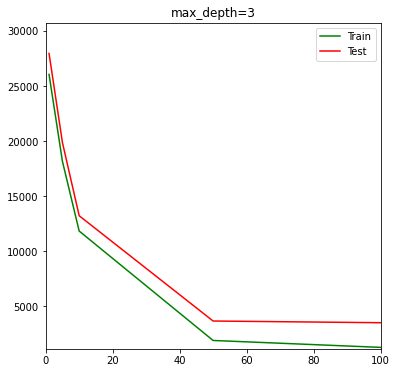

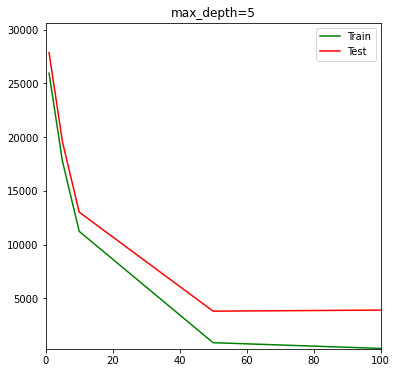

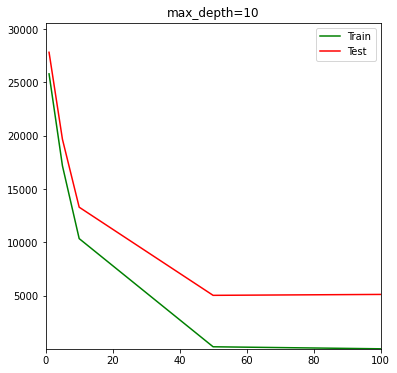

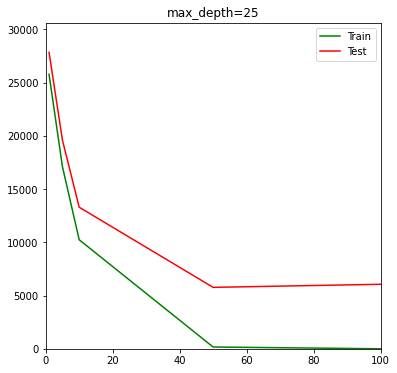

In [211]:
########### ИЗМЕНЕНИЕ #########

# обучаем модель для нескольких значений параметров и строим зависимости ошибки от этих параметров
n_trees_ls = [1, 5, 10, 50, 100]
max_depth_ls = [3, 5, 10, 25]
eta = 0.05

param_name, const_name = 'n_trees', 'max_depth'
param = (param_name, n_trees_ls)

for max_depth in max_depth_ls:
    train_errors = []
    test_errors = []
    const = (const_name, max_depth)
    for n_trees in n_trees_ls:
        trees, _, _ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_error, test_error = evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
        train_errors.append(train_error)
        test_errors.append(test_error)
    visualize_error(train_errors, test_errors, param, const)

1. Ошибка падает с ростом числа деревьев, постепенно выходя на плато, но при этом наблюдаются признаки переобучения: ошибка на трейне выходит на ноль, а на тесте - нет.
2. Глубина дерева слабо влияет на скорость сходимости ошибки от числа деревьев. С ростом глубины дерева переобучение становится выраженнее, то есть разница между ошибками на трейне и тесте увеличивается (при числе деревьев более 50). При малом числе деревьев наблюдается недообучение: высокие ошибки и на трейне, и на тесте.

ВЫВОД: Минимальная ошибка достигается при использовании простых базовых алгоритмов (малая глубина < 5 и числе деревьев около нескольких десятков).

<h3>Task 2<h3>

In [217]:
def gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, subsample_size=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    ########## ИЗМЕНЕНИЕ ##########
    size = X_train.shape[0]
    sample_indexes = list(range(size)) # создаем индексы в числе, равном числу объектов
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            
            ########## ИЗМЕНЕНИЕ ##########
            # делаем выборку 0.5 процентов от тренировочного датасета
            subsample_idxs = np.random.choice(sample_indexes, size=int(size*subsample_size), replace=False)
            X_train_random, y_train_random = X_train[subsample_idxs], y_train[subsample_idxs]
            
            tree.fit(X_train_random, y_train_random)
            
            train_errors.append(mean_squared_error(y_train_random, gb_predict(X_train_random, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            ########## ИЗМЕНЕНИЕ ##########
            # делаем выборку 0.5 процентов от тренировочного датасета
            subsample_idxs = np.random.choice(sample_indexes, size=int(size*subsample_size), replace=False)
            X_train_random, y_train_random = X_train[subsample_idxs], y_train[subsample_idxs]
            
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_random, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_random, residual(y_train_random, target))
            
            train_errors.append(mean_squared_error(y_train_random, gb_predict(X_train_random, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [218]:
def plot_error(train_errors, train_errors_st,test_errors, test_errors_st, n_tree, max_depth):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, n_tree)
    
    ax.plot(list(range(n_tree)), train_errors, ls=':', color='g', label='GB train', alpha=0.5)
    ax.plot(list(range(n_tree)), train_errors_st, ls=':', color='r', label='SGB train', alpha=0.5)
    ax.plot(list(range(n_tree)), test_errors, color='g', label='GB')
    ax.plot(list(range(n_tree)), test_errors_st, color='r', label='SGB')
    ax.legend()
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('MSE')
    ax.set_title(f'max_depth={max_depth}')

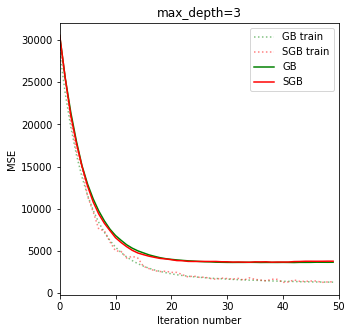

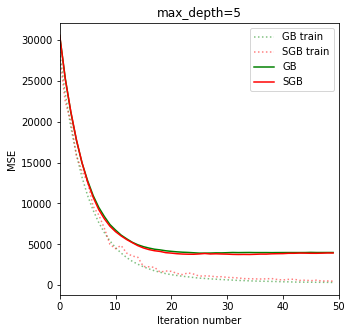

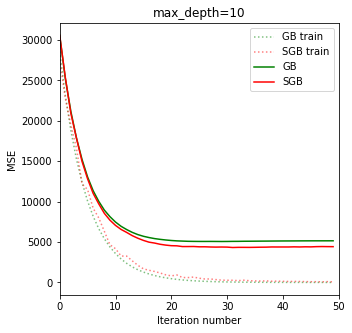

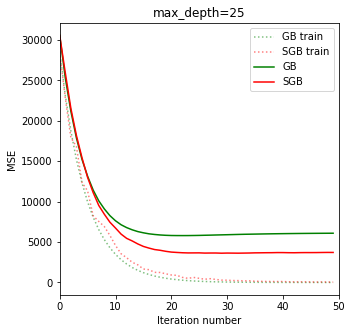

In [219]:
# строим зависимость ошибки от числа итераций для двух версий алгоритма
n_tree = 50
eta = 0.1

for max_depth in max_depth_ls:
    trees, train_errors, test_errors = gb_fit(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
    trees_st, train_errors_st, test_errors_st = gb_fit_stochastic(n_tree, max_depth, X_train, X_test, y_train, y_test, eta)
    plot_error(train_errors, train_errors_st, test_errors, test_errors_st, n_tree, max_depth)

На исследованном датасете не выявлено разницы в скорости сходимости (вероятно, ввиду малого размера датасета). Оба алгоритма при малых значениях глубины обучения демонстрируют примерно равную степень переобучения (разница между ошибкой на трейне и тесте).